# ver2.0
- 데이터 수집 :Data Augmentation 과정 수행
- 라이브러리 : tensorflow사용
- 모델 : pretrain이 되어있는 ResNet50 사용
- 파라미터 튜닝 더 정확하게 만들기

### Dataset

In [2]:
from selenium import webdriver
from bs4 import BeautifulSoup as bs
import pandas as pd
import time
from selenium.webdriver.common.keys import Keys

import os
from urllib.request import urlopen
from urllib.parse import quote_plus

In [3]:
base_dir = "./Data"

train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

train_p1_dir = os.path.join(train_dir, "금전수")
train_p2_dir = os.path.join(train_dir, "퓨미라")
train_p3_dir = os.path.join(train_dir, "식물 타라")
train_p4_dir = os.path.join(train_dir, "천냥금")
train_p5_dir = os.path.join(train_dir, "파키라")


test_p1_dir = os.path.join(test_dir, "금전수t")
test_p2_dir = os.path.join(test_dir, "퓨미라t")
test_p3_dir = os.path.join(test_dir, "식물 타라t")
test_p4_dir = os.path.join(test_dir, "천냥금t")
test_p5_dir = os.path.join(test_dir, "파키라t")

In [4]:
print("훈련용 금전수 데이터 개수 : ", len(os.listdir(train_p1_dir)))
print("훈련용 퓨미라 데이터 개수 : ", len(os.listdir(train_p2_dir)))
print("훈련용 식물 타라 데이터 개수 : ", len(os.listdir(train_p3_dir)))
print("훈련용 천냥금 데이터 개수 : ", len(os.listdir(train_p4_dir)))
print("훈련용 파키라 데이터 개수 : ", len(os.listdir(train_p5_dir)))

print("테스트용 금전수 데이터 개수 : ", len(os.listdir(test_p1_dir)))
print("테스트용 퓨미라 데이터 개수 : ", len(os.listdir(test_p2_dir)))
print("테스트용 식물 타라 데이터 개수 : ", len(os.listdir(test_p3_dir)))
print("테스트용 천냥금 데이터 개수 : ", len(os.listdir(test_p4_dir)))
print("테스트용 파키라 데이터 개수 : ", len(os.listdir(test_p5_dir)))

훈련용 금전수 데이터 개수 :  180
훈련용 퓨미라 데이터 개수 :  180
훈련용 식물 타라 데이터 개수 :  180
훈련용 천냥금 데이터 개수 :  180
훈련용 파키라 데이터 개수 :  180
테스트용 금전수 데이터 개수 :  20
테스트용 퓨미라 데이터 개수 :  20
테스트용 식물 타라 데이터 개수 :  20
테스트용 천냥금 데이터 개수 :  20
테스트용 파키라 데이터 개수 :  20


### 데이터 증식(Date Augmentation)
- 케라스에서 제공하는 이미지 제너레이터를 사용
- 학습데이터를 늘리고 변형에 강한 모델 구축 위함

In [4]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

rootPath = './Data'

imageGenerator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[.2, .2],
    horizontal_flip=True,
    validation_split=.1
)

trainGen = imageGenerator.flow_from_directory(
    os.path.join(rootPath, 'train'),
    target_size=(64, 64),
    subset='training'
)

validationGen = imageGenerator.flow_from_directory(
    os.path.join(rootPath, 'train'),
    target_size=(64, 64),
    subset='validation'
)

Found 810 images belonging to 5 classes.
Found 90 images belonging to 5 classes.


- rescale은 이미지의 nomalization을 위해 사용, 각 이미지별로 255로 나눈 값으로 데이터 변형
- rotation_range는 이미지의 최대 회전각을 지정, 최대 20도까지 회전
- width,height shift_range는 이미지의 이동을 말한다. 좌우, 위아래로 이미지의 이동하는 백분율을 지정(0.1은 10%)
- brightness_range는 이미지 밝기에 대한 내용
- horizontal_flip은 이미지의 수평 반전을 시켜준다. 이 옵션의 경우 데이터셋의 이해가 필요. 예를 들면 MNIST 데이터셋의 경우 손글씨 데이터이기 때문에 수평 반전이 일어나면 안된다.
- validation_split은 검증세트의 비율을 지정해준다.

- 설정한 이미지 제너레이터를 통해 특정 디렉터리의 데이터들을 손쉽게 불러올 수 있다.
- 현재 데이터셋 구성에 맞춰 폴더이름은 레이블명, 폴더안의 데이터는 해당 레이블의 데이터셋이 된다.
- target_size는 이미지를 해당 형태로 변형시켜주는데, 나는 64x64 사이즈로 데이터로 읽어옴.

### 모델 구성
- 먼저 간단한 cnn 모델 구성하여 학습까지 진행해보고자함

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

model = Sequential()

model.add(layers.InputLayer(input_shape=(64, 64, 3)))
model.add(layers.Conv2D(16, (3, 3), (1, 1), 'same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(rate=0.3))

model.add(layers.Conv2D(32, (3, 3), (1, 1), 'same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(rate=0.3))

model.add(layers.Conv2D(64, (3, 3), (1, 1), 'same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(rate=0.3))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(5, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        1

In [6]:
trainGen.samples

810

In [7]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy', 
    metrics=['acc'],
)

In [8]:
epochs = 32
history = model.fit_generator(
    trainGen, 
    epochs=epochs,
    steps_per_epoch=trainGen.samples / epochs, 
    validation_data=validationGen,
    validation_steps=trainGen.samples / epochs,
)

C:\Users\SMHRD\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/32
25/25 [==============================] - 4s 126ms/step - loss: 0.5553 - acc: 0.1937 - val_loss: 0.5790 - val_acc: 0.2000
Epoch 2/32
25/25 [==============================] - 2s 91ms/step - loss: 0.5044 - acc: 0.2162
Epoch 3/32
25/25 [==============================] - 2s 92ms/step - loss: 0.4987 - acc: 0.2614
Epoch 4/32
25/25 [==============================] - 2s 91ms/step - loss: 0.4896 - acc: 0.2832
Epoch 5/32
25/25 [==============================] - 2s 92ms/step - loss: 0.4822 - acc: 0.3299
Epoch 6/32
25/25 [==============================] - 2s 92ms/step - loss: 0.4796 - acc: 0.3421
Epoch 7/32
25/25 [==============================] - 2s 95ms/step - loss: 0.4663 - acc: 0.3703
Epoch 8/32
25/25 [==============================] - 2s 92ms/step - loss: 0.4602 - acc: 0.3724
Epoch 9/32
25/25 [==============================] - 2s 91ms/step - loss: 0.4493 - acc: 0.4155
Epoch 10/32
25/25 [==============================] - 2s 94ms/step - loss: 0.4551 - acc: 0.3692
Epoch 11/32
25/25 [==

### 학습결과 시각화 및 평가

In [9]:
import matplotlib.pyplot as plt

def show_graph(history_dict):
    accuracy = history_dict['acc']
    val_accuracy = history_dict['val_acc']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(loss) + 1)
    
    plt.figure(figsize=(16, 1))
    
    plt.subplot(121)
    plt.subplots_adjust(top=2)
    plt.plot(epochs, accuracy, 'ro', label='Training accuracy')
#    plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
    plt.title('Trainging and validation accuracy and loss')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy and Loss')

    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
              fancybox=True, shadow=True, ncol=5)
#     plt.legend(bbox_to_anchor=(1, -0.1))

    plt.subplot(122)
    plt.plot(epochs, loss, 'bo', label='Training loss')
#    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=5)
#     plt.legend(bbox_to_anchor=(1, 0))

    plt.show()

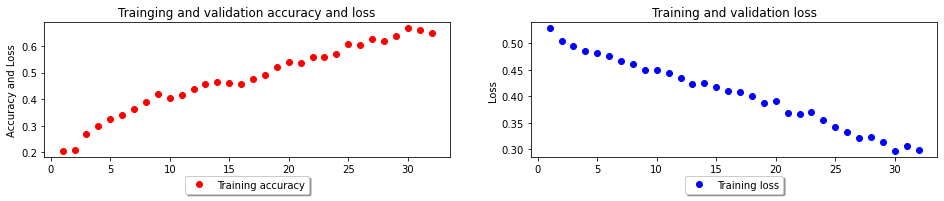

In [10]:
show_graph(history.history)

### 모델 중간 평가
- 현재 모델을 기준으로 테스트셋의 정확도와 손실율을 구해보려함.
- 테스트셋의 경우 rescale만 적용하여 원본 이미지 그대로 넣어줌.

In [11]:
testGenerator = ImageDataGenerator(
    rescale=1./255
)

testGen = imageGenerator.flow_from_directory(
    os.path.join(rootPath, 'test'),
    target_size=(64, 64),
)

model.evaluate_generator(testGen)

Found 100 images belonging to 5 classes.


C:\Users\SMHRD\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.41795074939727783, 0.5]

### 50%의 정확도를 보임
### 32에폭시 추가 실행해봄

In [12]:
epochs = 32
history = model.fit_generator(
    trainGen, 
    epochs=epochs,
    steps_per_epoch=trainGen.samples / epochs, 
    validation_data=validationGen,
    validation_steps=trainGen.samples / epochs,
)

Epoch 1/32
 1/25 [>.............................] - ETA: 1s - loss: 0.3728 - acc: 0.3000

C:\Users\SMHRD\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


25/25 [==============================] - 3s 106ms/step - loss: 0.2903 - acc: 0.6617 - val_loss: 0.4003 - val_acc: 0.5556
Epoch 2/32
25/25 [==============================] - 2s 92ms/step - loss: 0.2824 - acc: 0.6679
Epoch 3/32
25/25 [==============================] - 2s 91ms/step - loss: 0.2827 - acc: 0.6840: 0s - loss: 0.2833 - acc: 0
Epoch 4/32
25/25 [==============================] - 2s 94ms/step - loss: 0.2630 - acc: 0.7049
Epoch 5/32
25/25 [==============================] - 2s 95ms/step - loss: 0.2443 - acc: 0.7432
Epoch 6/32
25/25 [==============================] - 2s 97ms/step - loss: 0.2420 - acc: 0.7420
Epoch 7/32
25/25 [==============================] - 2s 94ms/step - loss: 0.2514 - acc: 0.7296
Epoch 8/32
25/25 [==============================] - 2s 95ms/step - loss: 0.2508 - acc: 0.7259
Epoch 9/32
25/25 [==============================] - 2s 96ms/step - loss: 0.2463 - acc: 0.7296
Epoch 10/32
25/25 [==============================] - 2s 95ms/step - loss: 0.2380 - acc: 0.7580
Epoc

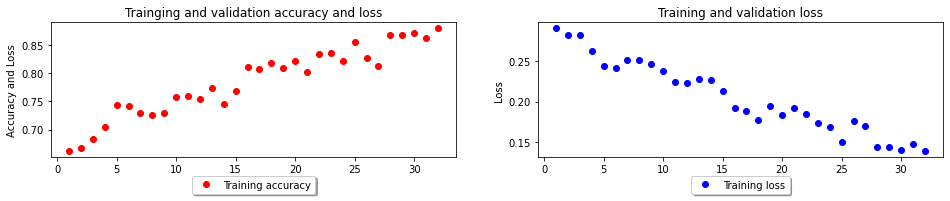

In [15]:
show_graph(history.history)

In [24]:
model.evaluate_generator(testGen)

[0.42954695224761963, 0.5699999928474426]

- 56%정확도로 상승
- 32에폭 더 수행해봄

In [25]:
epochs = 32
history = model.fit_generator(
    trainGen, 
    epochs=epochs,
    steps_per_epoch=trainGen.samples / epochs, 
    validation_data=validationGen,
    validation_steps=trainGen.samples / epochs,
)

Epoch 1/32
25/25 [==============================] - 3s 105ms/step - loss: 0.1099 - acc: 0.9025 - val_loss: 0.4996 - val_acc: 0.5778
Epoch 2/32
25/25 [==============================] - 2s 96ms/step - loss: 0.1387 - acc: 0.8630
Epoch 3/32
25/25 [==============================] - 2s 94ms/step - loss: 0.1376 - acc: 0.8691
Epoch 4/32
25/25 [==============================] - 2s 95ms/step - loss: 0.1360 - acc: 0.8741
Epoch 5/32
25/25 [==============================] - 2s 92ms/step - loss: 0.1162 - acc: 0.8901
Epoch 6/32
25/25 [==============================] - 2s 96ms/step - loss: 0.1184 - acc: 0.8790
Epoch 7/32
25/25 [==============================] - 2s 95ms/step - loss: 0.1212 - acc: 0.8938
Epoch 8/32
25/25 [==============================] - 2s 93ms/step - loss: 0.1133 - acc: 0.9012
Epoch 9/32
25/25 [==============================] - 2s 95ms/step - loss: 0.1059 - acc: 0.9235
Epoch 10/32
25/25 [==============================] - 2s 94ms/step - loss: 0.0944 - acc: 0.9173: 0s - loss: 0.0941 - 

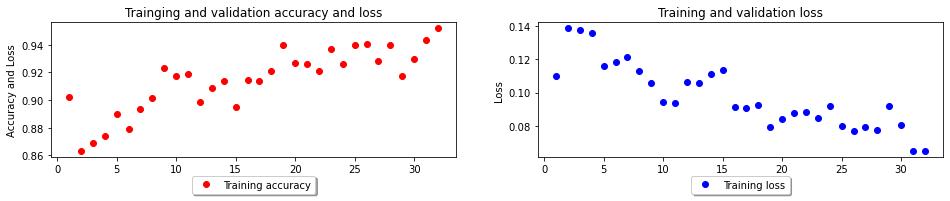

In [26]:
show_graph(history.history)

In [27]:
model.evaluate_generator(testGen)

[0.5144991874694824, 0.6000000238418579]

- 60%까지는 정확도가 올라오지만 더이상 에폭시 더 학습 시키는 방식으로는 정확도 정체

### 모델 예측

In [28]:
from tensorflow.keras.preprocessing.image import array_to_img
import numpy as np

예측: 금전수
정답: 금전수


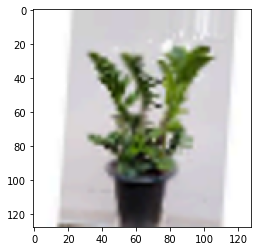

In [32]:
cls_index = ['금전수','퓨미라','식물 타라','천냥금','파키라']

imgs = testGen.next()
arr = imgs[0][0]
img = array_to_img(arr).resize((128, 128))
plt.imshow(img)
result = model.predict_classes(arr.reshape(1, 64, 64, 3))
print('예측: {}'.format(cls_index[result[0]]))
print('정답: {}'.format(cls_index[np.argmax(imgs[1][0])]))

예측: 파키라
정답: 식물 타라


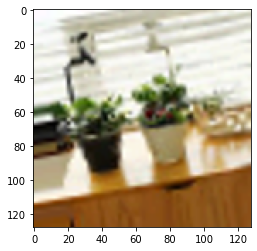

In [35]:
cls_index = ['금전수','퓨미라','식물 타라','천냥금','파키라']

imgs = testGen.next()
arr = imgs[0][0]
img = array_to_img(arr).resize((128, 128))
plt.imshow(img)
result = model.predict_classes(arr.reshape(1, 64, 64, 3))
print('예측: {}'.format(cls_index[result[0]]))
print('정답: {}'.format(cls_index[np.argmax(imgs[1][0])]))

예측: 금전수
정답: 금전수


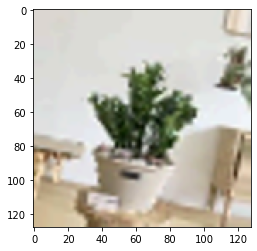

In [37]:
cls_index = ['금전수','퓨미라','식물 타라','천냥금','파키라']

imgs = testGen.next()
arr = imgs[0][0]
img = array_to_img(arr).resize((128, 128))
plt.imshow(img)
result = model.predict_classes(arr.reshape(1, 64, 64, 3))
print('예측: {}'.format(cls_index[result[0]]))
print('정답: {}'.format(cls_index[np.argmax(imgs[1][0])]))

### 평가
- 기본적으로 설계해본 cnn모델만으로는 정확도 부분에서 50~60%대에서 머무르며, 실제 예측 결과 역시 오답과 정답이 반복된다
- 데이터 셋 처리 해줬을때 상승은 할 수 있을것으로 보이나, 적절한 모델 구성은 되지 않은 것으로 보임

## ResNet50 모델 사용

- Dataset 동일하게 사용
- 제너레이터 동일하게 사용

In [6]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 위노그라드 알고리즘 설정
os.environ['TF_ENABLE_WINOGRAD_NONFUSED'] = '1'

rootPath = './Data'

imageGenerator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[.2, .2],
    horizontal_flip=True,
    validation_split=.1
)

trainGen = imageGenerator.flow_from_directory(
    os.path.join(rootPath, 'train'),
    target_size=(64, 64),
    subset='training'
)

validationGen = imageGenerator.flow_from_directory(
    os.path.join(rootPath, 'train'),
    target_size=(64, 64),
    subset='validation'
)

Found 810 images belonging to 5 classes.
Found 90 images belonging to 5 classes.


### 모델 구성(ResNet)
- 텐서플로 케라스에서 ResNet 모델을 제공해주고 있으며, 해당 모델의 구성을 그대로 가져다 사용함
- 먼저 이미지넷 학습하지 않은 상태의 ResNet모델 사용 -> 이미지넷 선 학습 + 전이학습 모델 사용

In [7]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

model2 = Sequential()
model2.add(ResNet50(include_top=True, weights=None, input_shape=(64, 64, 3), classes=5))
### 가중치 weights부분 수정해야
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 5)                 23597957  
Total params: 23,597,957
Trainable params: 23,544,837
Non-trainable params: 53,120
_________________________________________________________________


- include_top : 모델의 최상위 Fully Connected 레이어를 추가할것인지 추가하지 않을것인지에 대한 토글입니다.
- weights : 기존 학습된 가중치 데이터를 읽어들일 가중치 경로, imagenet이라 입력하면 imagenet 데이터셋을 기반으로 기존 학습된 가중치 데이터를 불러옵니다.
- input_shape : 입력값의 형태를 지정 3D 텐서를 입력해야한다.
- classes : 모델의 마지막 출력 차원을 지정
- ResNet50 모델을 이용하여 학습모델을 학습

### 모델 컴파일
- 모델 구성 후 컴파일 필수

In [8]:
model2.compile(
    optimizer='adam',
    loss='binary_crossentropy', 
    metrics=['acc'],
)

### 학습 시작


In [9]:
epochs = 32
history = model2.fit_generator(
    trainGen, 
    epochs=epochs,
    steps_per_epoch=trainGen.samples / epochs, 
    validation_data=validationGen,
    validation_steps=trainGen.samples / epochs,
)

C:\Users\SMHRD\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/32
25/25 [==============================] - 37s 1s/step - loss: 0.8053 - acc: 0.2365 - val_loss: 0.5919 - val_acc: 0.2000
Epoch 2/32
25/25 [==============================] - 28s 1s/step - loss: 0.4997 - acc: 0.3354
Epoch 3/32
25/25 [==============================] - 28s 1s/step - loss: 0.5137 - acc: 0.4006
Epoch 4/32
25/25 [==============================] - 28s 1s/step - loss: 0.4581 - acc: 0.4378
Epoch 5/32
25/25 [==============================] - 29s 1s/step - loss: 0.4362 - acc: 0.5027
Epoch 6/32
25/25 [==============================] - 29s 1s/step - loss: 0.4221 - acc: 0.5128
Epoch 7/32
25/25 [==============================] - 29s 1s/step - loss: 0.4119 - acc: 0.5218
Epoch 8/32
25/25 [==============================] - 29s 1s/step - loss: 0.3860 - acc: 0.5596
Epoch 9/32
25/25 [==============================] - 29s 1s/step - loss: 0.3436 - acc: 0.6402
Epoch 10/32
25/25 [==============================] - 29s 1s/step - loss: 0.3827 - acc: 0.5852
Epoch 11/32
25/25 [=============

### 학습결과 시각화

In [14]:
import matplotlib.pyplot as plt

def show_graph(history_dict):
    accuracy = history_dict['acc']
    val_accuracy = history_dict['val_acc']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(loss) + 1)
    
    plt.figure(figsize=(16, 1))
    
    plt.subplot(121)
    plt.subplots_adjust(top=2)
    plt.plot(epochs, accuracy, 'ro', label='Training accuracy')
#    plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
    plt.title('Trainging and validation accuracy and loss')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy and Loss')

    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
              fancybox=True, shadow=True, ncol=5)
#     plt.legend(bbox_to_anchor=(1, -0.1))

    plt.subplot(122)
    plt.plot(epochs, loss, 'bo', label='Training loss')
#    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=5)
#     plt.legend(bbox_to_anchor=(1, 0))

    plt.show()

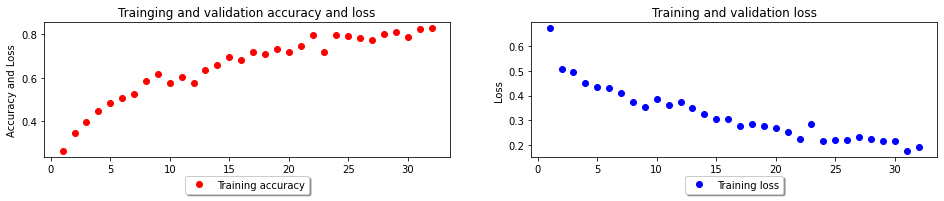

In [16]:
show_graph(history.history)

그래프의 변동이 심하니 지수 이동 평균값을 구하여 그래프를 다시 그린다

In [17]:
def smooth_curve(points, factor=.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

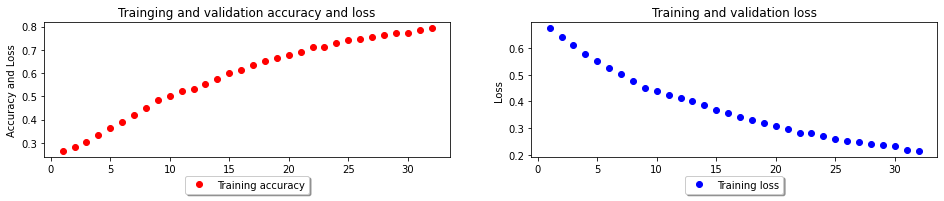

In [18]:
smooth_data = {}
for key, val in history.history.items():
    smooth_data[key] = smooth_curve(val)
show_graph(smooth_data)


### 모델 중간 평가
- 테스트셋의 경우 rescale만 적용하여 원본 이미지 그대로 사용

In [21]:
testGenerator = ImageDataGenerator(
    rescale=1./255
)

testGen = imageGenerator.flow_from_directory(
    os.path.join(rootPath, 'test'),
    target_size=(64, 64),
)

model2.evaluate_generator(testGen)

Found 100 images belonging to 5 classes.


[0.6122758984565735, 0.44999998807907104]

- 정확도 44%로 기본 cnn모델 보다도 낮게 나옴
- 추가 에폭시 돌려보면 정확도가 상승 될 것으로 예상은 되지만 기본적으로 모델 구성에 문제가 있음
- ResNet 모델에 가중치 추가하여 정확도 올려야 함

### 모델 추가 학습
- 과소적합 예상될 경우 추가 에폭시 만큼 수행

In [66]:
epochs = 32
history = model2.fit_generator(
    trainGen, 
    epochs=epochs,
    steps_per_epoch=trainGen.samples / epochs, 
    validation_data=validationGen,
    validation_steps=trainGen.samples / epochs,
)

Epoch 1/32
25/25 [==============================] - 27s 1s/step - loss: 0.3093 - acc: 0.6914 - val_loss: 0.4128 - val_acc: 0.5444
Epoch 2/32
25/25 [==============================] - 27s 1s/step - loss: 0.2776 - acc: 0.7148
Epoch 3/32
25/25 [==============================] - 27s 1s/step - loss: 0.2485 - acc: 0.7617
Epoch 4/32
25/25 [==============================] - 27s 1s/step - loss: 0.2572 - acc: 0.7333
Epoch 5/32
25/25 [==============================] - 27s 1s/step - loss: 0.2503 - acc: 0.7543
Epoch 6/32
25/25 [==============================] - 27s 1s/step - loss: 0.2196 - acc: 0.7716
Epoch 7/32
25/25 [==============================] - 28s 1s/step - loss: 0.1925 - acc: 0.8012
Epoch 8/32
25/25 [==============================] - 27s 1s/step - loss: 0.2713 - acc: 0.7247
Epoch 9/32
25/25 [==============================] - 29s 1s/step - loss: 0.3196 - acc: 0.6741
Epoch 10/32
25/25 [==============================] - 28s 1s/step - loss: 0.2700 - acc: 0.7296
Epoch 11/32
25/25 [=============

### 학습결과 시각화
- 지수이동평균을 적용하여 그래프

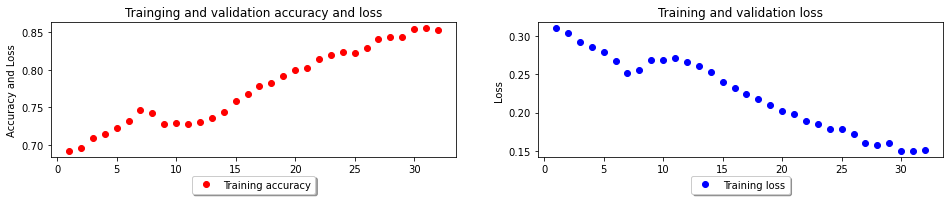

In [67]:
smooth_data = {}
for key, val in history.history.items():
    smooth_data[key] = smooth_curve(val)
show_graph(smooth_data)

In [73]:
testGenerator = ImageDataGenerator(
    rescale=1./255
)

testGen = imageGenerator.flow_from_directory(
    os.path.join(rootPath, 'test'),
    target_size=(64, 64),
)

model2.evaluate_generator(testGen)

Found 100 images belonging to 5 classes.


[0.6234659552574158, 0.47999998927116394]

예측: 금전수
정답: 금전수


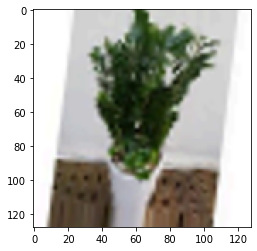

In [74]:
cls_index = ['금전수','퓨미라','식물 타라','천냥금','파키라']

imgs = testGen.next()
arr = imgs[0][0]
img = array_to_img(arr).resize((128, 128))
plt.imshow(img)
result = model2.predict_classes(arr.reshape(1, 64, 64, 3))
print('예측: {}'.format(cls_index[result[0]]))
print('정답: {}'.format(cls_index[np.argmax(imgs[1][0])]))

예측: 퓨미라
정답: 파키라


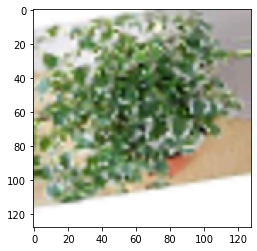

In [75]:
cls_index = ['금전수','퓨미라','식물 타라','천냥금','파키라']

imgs = testGen.next()
arr = imgs[0][0]
img = array_to_img(arr).resize((128, 128))
plt.imshow(img)
result = model2.predict_classes(arr.reshape(1, 64, 64, 3))
print('예측: {}'.format(cls_index[result[0]]))
print('정답: {}'.format(cls_index[np.argmax(imgs[1][0])]))

- 정확도 낮아 정답과 오류가 반복됌

# Fine Tuning
- ResNet의 정확도를 높이기 위해, 튜닝을 진행
- 특성 추출의 경우, 이미지넷 학습된 resnet모델 자체가 식물 데이터 학습이 된 것이 아니기 때문에 특성을 추출하는 부분은 크게 의미가 없다고 판단해서 생략

- Find Tuning이란 미세조정
- 아무래도 기존 학습된 네트워크는 학습한 데이터셋에 잘맞도록 학습이 되어 있다.
- 그렇다고 우리 데이터셋으로 밑바닥부터 학습시키기엔 데이터를 모으기가 힘든 경우가 대다수.
- 이런 경우에 학습된 네트워크를 미세조정하여 우리의 데이터셋에 조금 더 잘 맞도록 모델의 파라메터를 조정하는 과정을 거치는 데, 이 과정을 Fine Tuning이라고 한다.

순서
- 분류기를 학습한다. (이때 분류기를 제외한 모델의 모든 레이어는 가중치를 업데이트 되지 않도록 동결(Freeze) 시킨다)
- 모델의 마지막 레이어들을 미세조정을 실시한다.

In [195]:
resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(64, 64, 3), classes=5)

In [196]:
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_25[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [212]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten

model3 = Sequential()

model3.add(resnet)
model3.add(Flatten())
model3.add(Dense(units=5, activation="softmax"))

model3.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2, 2, 2048)        23587712  
_________________________________________________________________
flatten_7 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 5)                 40965     
Total params: 23,628,677
Trainable params: 1,095,685
Non-trainable params: 22,532,992
_________________________________________________________________


In [213]:
model3.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['acc'])

In [214]:
epochs = 32
history = model3.fit_generator(
    trainGen, 
    epochs=epochs,
    steps_per_epoch=trainGen.samples / epochs, 
    validation_data=validationGen,
    validation_steps=trainGen.samples / epochs,
)

Epoch 1/32
25/25 [==============================] - 8s 240ms/step - loss: 0.5729 - acc: 0.1893 - val_loss: 0.5161 - val_acc: 0.3000
Epoch 2/32
25/25 [==============================] - 5s 195ms/step - loss: 0.4800 - acc: 0.3109
Epoch 3/32
25/25 [==============================] - 5s 205ms/step - loss: 0.4748 - acc: 0.3248
Epoch 4/32
25/25 [==============================] - 5s 203ms/step - loss: 0.4668 - acc: 0.3339
Epoch 5/32
25/25 [==============================] - 5s 201ms/step - loss: 0.4641 - acc: 0.3512
Epoch 6/32
25/25 [==============================] - 5s 207ms/step - loss: 0.4470 - acc: 0.3972
Epoch 7/32
25/25 [==============================] - 5s 206ms/step - loss: 0.4570 - acc: 0.3754
Epoch 8/32
25/25 [==============================] - 5s 207ms/step - loss: 0.4417 - acc: 0.4154
Epoch 9/32
25/25 [==============================] - 6s 216ms/step - loss: 0.4408 - acc: 0.4199
Epoch 10/32
25/25 [==============================] - 5s 208ms/step - loss: 0.4453 - acc: 0.4161
Epoch 11/32


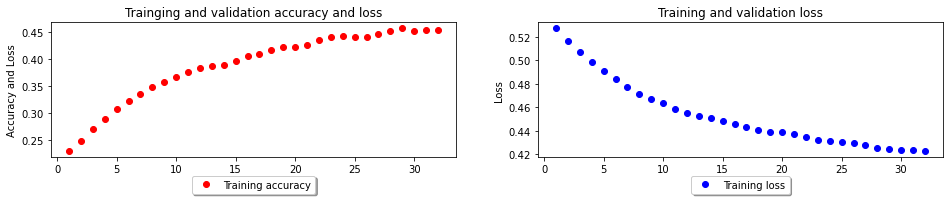

In [215]:
smooth_data = {}
for key, val in history.history.items():
    smooth_data[key] = smooth_curve(val)
show_graph(smooth_data)

In [216]:
testGenerator = ImageDataGenerator(
    rescale=1./255
)

testGen = imageGenerator.flow_from_directory(
    os.path.join(rootPath, 'test'),
    target_size=(64, 64),
)

model3.evaluate_generator(testGen)

Found 100 images belonging to 5 classes.


[1.027032732963562, 0.23000000417232513]

예측: 파키라
정답: 금전수


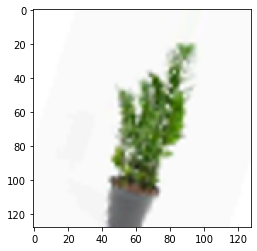

In [229]:
cls_index = ['금전수','퓨미라','식물 타라','천냥금','파키라']

imgs = testGen.next()
arr = imgs[0][0]
img = array_to_img(arr).resize((128, 128))
plt.imshow(img)
result = model3.predict_classes(arr.reshape(1, 64, 64, 3))
print('예측: {}'.format(cls_index[result[0]]))
print('정답: {}'.format(cls_index[np.argmax(imgs[1][0])]))

- resnet모델 동결화 작업없이 진행했을때 정확도 20%대로 좋지 않음을 알 수 있었음
- 제일 아래층부터 하나씩 동결화 작업 진행해 볼것

In [230]:
resnet.trainable = True

set_trainable = False

# conv_base 모델의 레이어를 하나씩 가져온다
for layer in resnet.layers :
    # 레이어 이름이 block5_conv1이면 동결을 풀어줌
    if layer.name == "conv5_block3_3_conv" :
        set_trainable = True
#    if layer.name == "conv5_block3_2_conv" :
#        set_trainable = True 
    if set_trainable :
        layer.trainable = True
    else :
        layer.trainable = False

In [231]:
resnet.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['acc'])

In [233]:
model3.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['acc'])

In [ ]:
epochs = 32
history = resnet.fit_generator(
    trainGen, 
    epochs=epochs,
    steps_per_epoch=trainGen.samples / epochs, 
    validation_data=validationGen,
    validation_steps=trainGen.samples / epochs,
)

In [234]:
epochs = 32
history = model3.fit_generator(
    trainGen, 
    epochs=epochs,
    steps_per_epoch=trainGen.samples / epochs, 
    validation_data=validationGen,
    validation_steps=trainGen.samples / epochs,
)

Epoch 1/32
25/25 [==============================] - 9s 281ms/step - loss: 0.5616 - acc: 0.3617 - val_loss: 0.4870 - val_acc: 0.3556
Epoch 2/32
25/25 [==============================] - 6s 235ms/step - loss: 0.4451 - acc: 0.4005
Epoch 3/32
25/25 [==============================] - 6s 236ms/step - loss: 0.4404 - acc: 0.4082
Epoch 4/32
25/25 [==============================] - 6s 239ms/step - loss: 0.4409 - acc: 0.4210
Epoch 5/32
25/25 [==============================] - 6s 233ms/step - loss: 0.4372 - acc: 0.4486
Epoch 6/32
25/25 [==============================] - 6s 239ms/step - loss: 0.4387 - acc: 0.4615
Epoch 7/32
25/25 [==============================] - 6s 238ms/step - loss: 0.4245 - acc: 0.4716
Epoch 8/32
25/25 [==============================] - 6s 237ms/step - loss: 0.4378 - acc: 0.4322
Epoch 9/32
25/25 [==============================] - 6s 244ms/step - loss: 0.4130 - acc: 0.4951
Epoch 10/32
25/25 [==============================] - 6s 248ms/step - loss: 0.4365 - acc: 0.4451
Epoch 11/32


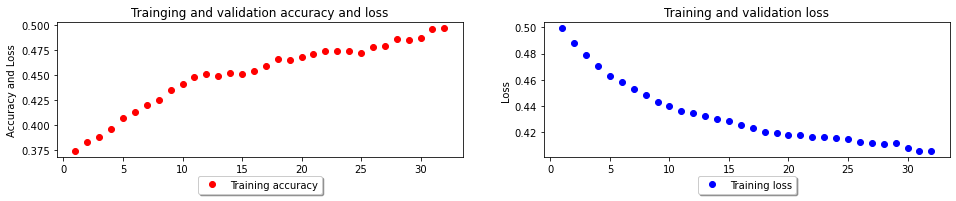

In [240]:
smooth_data = {}
for key, val in history.history.items():
    smooth_data[key] = smooth_curve(val)
show_graph(smooth_data)

In [241]:
testGenerator = ImageDataGenerator(
    rescale=1./255
)

testGen = imageGenerator.flow_from_directory(
    os.path.join(rootPath, 'test'),
    target_size=(64, 64),
)

model3.evaluate_generator(testGen)

Found 100 images belonging to 5 classes.


[0.4416699707508087, 0.46000000834465027]

예측: 금전수
정답: 금전수


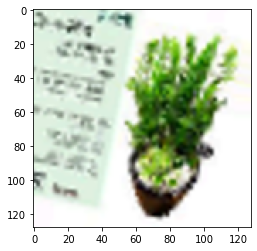

In [243]:
cls_index = ['금전수','퓨미라','식물 타라','천냥금','파키라']

imgs = testGen.next()
arr = imgs[0][0]
img = array_to_img(arr).resize((128, 128))
plt.imshow(img)
result = model3.predict_classes(arr.reshape(1, 64, 64, 3))
print('예측: {}'.format(cls_index[result[0]]))
print('정답: {}'.format(cls_index[np.argmax(imgs[1][0])]))

- resnet 모델에서 동결하지 않는 층을 한개에서 두개로 올리니 정확도가 20%대에서 40%대로 증가하였다
- 아직 정확도 부족 오답과 정답 반복
- 2개에서 3개층으로 늘려서 진행해볼것

In [244]:
resnet.trainable = True

set_trainable = False

# conv_base 모델의 레이어를 하나씩 가져온다
for layer in resnet.layers :
    # 레이어 이름이 block5_conv1이면 동결을 풀어줌
    if layer.name == "conv5_block3_3_conv" :
        set_trainable = True
    if layer.name == "conv5_block3_2_conv" :
        set_trainable = True 
    if layer.name == "conv5_block3_1_conv" :
        set_trainable = True 
    if set_trainable :
        layer.trainable = True
    else :
        layer.trainable = False

In [245]:
resnet.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['acc'])

In [246]:
model3.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['acc'])

In [247]:
epochs = 32
history = model3.fit_generator(
    trainGen, 
    epochs=epochs,
    steps_per_epoch=trainGen.samples / epochs, 
    validation_data=validationGen,
    validation_steps=trainGen.samples / epochs,
)

Epoch 1/32
25/25 [==============================] - 11s 340ms/step - loss: 0.4537 - acc: 0.4352 - val_loss: 0.4753 - val_acc: 0.4111
Epoch 2/32
25/25 [==============================] - 8s 330ms/step - loss: 0.4305 - acc: 0.4501
Epoch 3/32
25/25 [==============================] - 9s 341ms/step - loss: 0.4281 - acc: 0.4609
Epoch 4/32
25/25 [==============================] - 8s 329ms/step - loss: 0.4376 - acc: 0.4209
Epoch 5/32
25/25 [==============================] - 8s 330ms/step - loss: 0.4094 - acc: 0.4961
Epoch 6/32
25/25 [==============================] - 9s 339ms/step - loss: 0.4084 - acc: 0.4773
Epoch 7/32
25/25 [==============================] - 8s 319ms/step - loss: 0.4239 - acc: 0.4647
Epoch 8/32
25/25 [==============================] - 8s 320ms/step - loss: 0.4178 - acc: 0.4693
Epoch 9/32
25/25 [==============================] - 8s 326ms/step - loss: 0.4286 - acc: 0.4632
Epoch 10/32
25/25 [==============================] - 8s 327ms/step - loss: 0.3897 - acc: 0.5063
Epoch 11/32

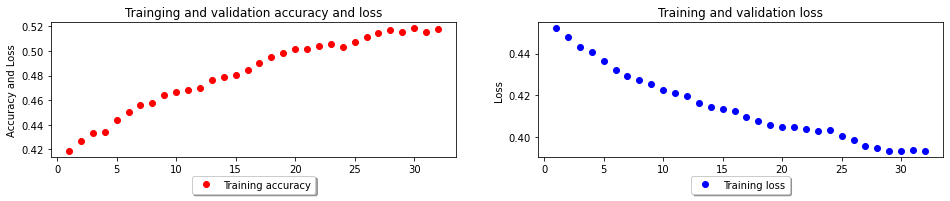

In [248]:
smooth_data = {}
for key, val in history.history.items():
    smooth_data[key] = smooth_curve(val)
show_graph(smooth_data)

In [262]:
testGenerator = ImageDataGenerator(
    rescale=1./255
)

testGen = imageGenerator.flow_from_directory(
    os.path.join(rootPath, 'test'),
    target_size=(64, 64),
)

model3.evaluate_generator(testGen)

Found 100 images belonging to 5 classes.


[0.45593884587287903, 0.4300000071525574]

예측: 식물 타라
정답: 천냥금


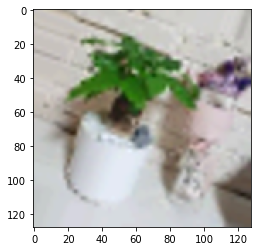

In [269]:
cls_index = ['금전수','퓨미라','식물 타라','천냥금','파키라']

imgs = testGen.next()
arr = imgs[0][0]
img = array_to_img(arr).resize((128, 128))
plt.imshow(img)
result = model3.predict_classes(arr.reshape(1, 64, 64, 3))
print('예측: {}'.format(cls_index[result[0]]))
print('정답: {}'.format(cls_index[np.argmax(imgs[1][0])]))

- 정확도가 별로 올라가지 않음...
- 전이학습 방식이 정확하지 않은듯 하다... 피드백이 필요함 ㅠㅠ

#### 미세조정
- 전이학습 모델을 마지막 층 부분까지 학습이 되도록 조정하는 것

In [ ]:
# VGG15의 5번째 레이어만 동결을 풀어줌
resnet.trainable = True

set_trainable = False

# conv_base 모델의 레이어를 하나씩 가져온다
for layer in resnet.layers :
    # 레이어 이름이 block5_conv1이면 동결을 풀어줌
    if layer.name == "conv5_block3_3_conv" :
        set_trainable = True
        
    if set_trainable :
        layer.trainable = True
    else :
        layer.trainable = False

In [316]:
model5.compile(
    optimizer='adam',
    loss='binary_crossentropy', 
    metrics=['acc'],
)

In [397]:
epochs = 32
history = model5.fit_generator(
    trainGen, 
    epochs=epochs,
    steps_per_epoch=trainGen.samples / epochs, 
    validation_data=validationGen,
    validation_steps=trainGen.samples / epochs,
)

Epoch 1/32
25/25 [==============================] - 8s 324ms/step - loss: 0.4687 - acc: 0.3506 - val_loss: 0.5017 - val_acc: 0.2333
Epoch 2/32
25/25 [==============================] - 8s 319ms/step - loss: 0.4666 - acc: 0.3630
Epoch 3/32
25/25 [==============================] - 8s 316ms/step - loss: 0.4686 - acc: 0.3519
Epoch 4/32
25/25 [==============================] - 8s 316ms/step - loss: 0.4719 - acc: 0.3642
Epoch 5/32
25/25 [==============================] - 8s 325ms/step - loss: 0.4630 - acc: 0.3840
Epoch 6/32
25/25 [==============================] - 8s 327ms/step - loss: 0.4632 - acc: 0.3889
Epoch 7/32
25/25 [==============================] - 8s 333ms/step - loss: 0.4675 - acc: 0.3556
Epoch 8/32
25/25 [==============================] - 8s 333ms/step - loss: 0.4734 - acc: 0.3741
Epoch 9/32
25/25 [==============================] - 9s 335ms/step - loss: 0.4732 - acc: 0.3593
Epoch 10/32
25/25 [==============================] - 9s 337ms/step - loss: 0.4710 - acc: 0.3346
Epoch 11/32


In [ ]:
- resnet 모델의 레이어들을 뒤쪽부분의 동결 풀어주면서 학습을 진행 하기 -> 